In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

import pysta
import stc
%load_ext autoreload
%autoreload 2

In [2]:
# load data

# load stim and spike data
# dataset_name = "20180618"
# dataset_name = "20180621"
dataset_name = "20180626"
# dataset_name = "20180828"

dataset_filename = "data/{}.mat".format(dataset_name)

stim, spike_train, info = pysta.load_data(dataset_filename)

channel_names = [ch.replace("ch_","") for ch in info["channel_names"]]
# info["channel_names"]

# load cell type
cell_types = pd.read_csv("data/{}_cell_type.csv".format(dataset_name))
# cell_types

List of arrays in this file: 
 <KeysViewHDF5 ['#refs#', 'channel_names', 'height', 'sampling_rate', 'spike_train', 'stim', 'width']>
Shape of the array stim:  (64, 9000)
Shape of the array spike_train:  (118, 9000)
length of the list channel_names:  118
sampling_rate:  10.0


In [3]:
# calc number of spikes
tap = 8 # -700 ms ~ 0

num_samples = list()
for idx in range(spike_train.shape[0]):    
    spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[idx], tap)
    num_samples.append(spike_triggered_stim.shape[0])

num_samples_df = pd.DataFrame({"channel_name": channel_names, "number_of_samples": num_samples})
# num_samples_df

## check the effect of smoothing on the largest eigenvalue($\lambda_1$)

In [4]:
# read eigenvalues

# helper function
def read_eigen_values(folder_name, channel_names):
    all_eig_values = dict()
    largest_eig_values = list()

    for channel_name in channel_names:
        filename = "{}/ch_{}_eig_val.txt".format(folder_name,channel_name)
        eig_val = np.loadtxt(filename)

        all_eig_values[channel_name] = eig_val
    #     eigen_values.append(eig_val)
        largest_eig_values.append(eig_val[0])
    return all_eig_values, largest_eig_values
    

folder_name = "{}_stc_tap{}".format(dataset_name,tap)
all_eig_values, largest_eig_values = read_eigen_values(folder_name, channel_names)
# convert to DataFrame
result_eig = pd.DataFrame({"channel_name": channel_names, "largest_eig_values":largest_eig_values})

folder_name = "{}_stc_tap{}_smoothed".format(dataset_name,tap)
all_eig_values, largest_eig_values = read_eigen_values(folder_name, channel_names)
# convert to DataFrame
result_eig_smoothed = pd.DataFrame({"channel_name": channel_names, "largest_eig_values":largest_eig_values})

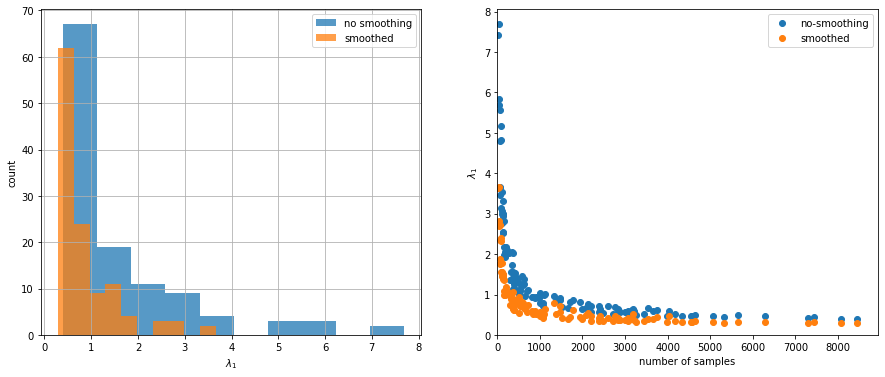

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(121)
result_eig["largest_eig_values"].hist(alpha=0.75)
result_eig_smoothed["largest_eig_values"].hist(alpha=0.75)
plt.grid("off")
plt.xlabel("$\lambda_1$")
plt.ylabel("count")

plt.legend(["no smoothing", "smoothed"])

plt.subplot(122)
# merge with num_samples
num_samples_eig = num_samples_df.merge(result_eig)
num_samples_eig_smoothed = num_samples_df.merge(result_eig_smoothed)

plt.scatter(num_samples_eig["number_of_samples"], num_samples_eig["largest_eig_values"])
plt.scatter(num_samples_eig_smoothed["number_of_samples"], num_samples_eig_smoothed["largest_eig_values"])
plt.xlabel('number of samples')
plt.ylabel('$\lambda_1$')
plt.xlim(0,plt.xlim()[1])
plt.ylim(0,plt.ylim()[1])


plt.legend(["no-smoothing", "smoothed"])
# see https://arxiv.org/pdf/0901.3245.pdf to understand the effect of # samples on the largest eigenvalue

plt.savefig("eig_smoothed_{}.pdf".format(dataset_name))